# GNN Exploration

In [6]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

In [7]:
# HOVERNET MODEL

from src.model.architectures.graph_construction.hover_net import HoVerNet
chkpt = "HoVerNet_MD-1.3.ckpt"
chkpt_path = os.path.join(parent,"experiments","checkpoints",chkpt)

cell_seg_model = HoVerNet.load_from_checkpoint(chkpt_path, RESNET_SIZE=50,START_LR=0)

from src.datasets.BACH import BACH
src_folder = os.path.join(parent,"data","processed","BACH_TRAIN")
prc_folder = os.path.join(parent,"data","processed","BACH_TRAIN","INSTANCE_SEGMENTATION")

In [8]:
# DATA




from tqdm import tqdm
from PIL import Image
from src.transforms.graph_construction.hovernet_post_processing import *
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import adjust_sharpness

def process(): # USE OF SHARPEN IS IMPORTANT TO CREATE MORE DISTINCTIVE CELLS
    """Takes all the BACH images and performs instance segmentation so that the graph constructors may be called later.
    """
    bach = BACH(src_folder, prc_folder, cell_seg_model, ids=[1,2,3])

    img_transform = Compose(
                [ToTensor()]) #(lambda x: adjust_sharpness(x,20))])
    normalizer = Normalize((0.6441, 0.4474, 0.6039), (0.1892, 0.1922, 0.1535))
    for path in tqdm(bach.raw_paths, desc="Creating Graphs from BACH"):
        img = Image.open(path)
        
        orig_img = img_transform(img)
        img = normalizer(orig_img.clone())
        
        ins_pred = instance_mask_prediction_hovernet(cell_seg_model, img, tile_size=128, pre_normalized=True)
        
        img = cut_img_from_tile(img, tile_size=128)
        orig_img = cut_img_from_tile(orig_img, tile_size=128)
        
        assert img.shape[1:] == ins_pred.shape[:]
        
        data = {"image": img, "instance_mask": ins_pred,"original_image": orig_img}
        file_name = os.path.basename(path)[:-4] + ".pt"
        proc_path = os.path.join(bach.processed_dir, file_name)
        torch.save(data, proc_path)


In [9]:
process()

Creating Graphs from BACH:   0%|          | 0/12 [00:31<?, ?it/s]


KeyboardInterrupt: 

Hollowing: 100%|██████████| 1408/1408 [01:58<00:00, 11.84it/s]


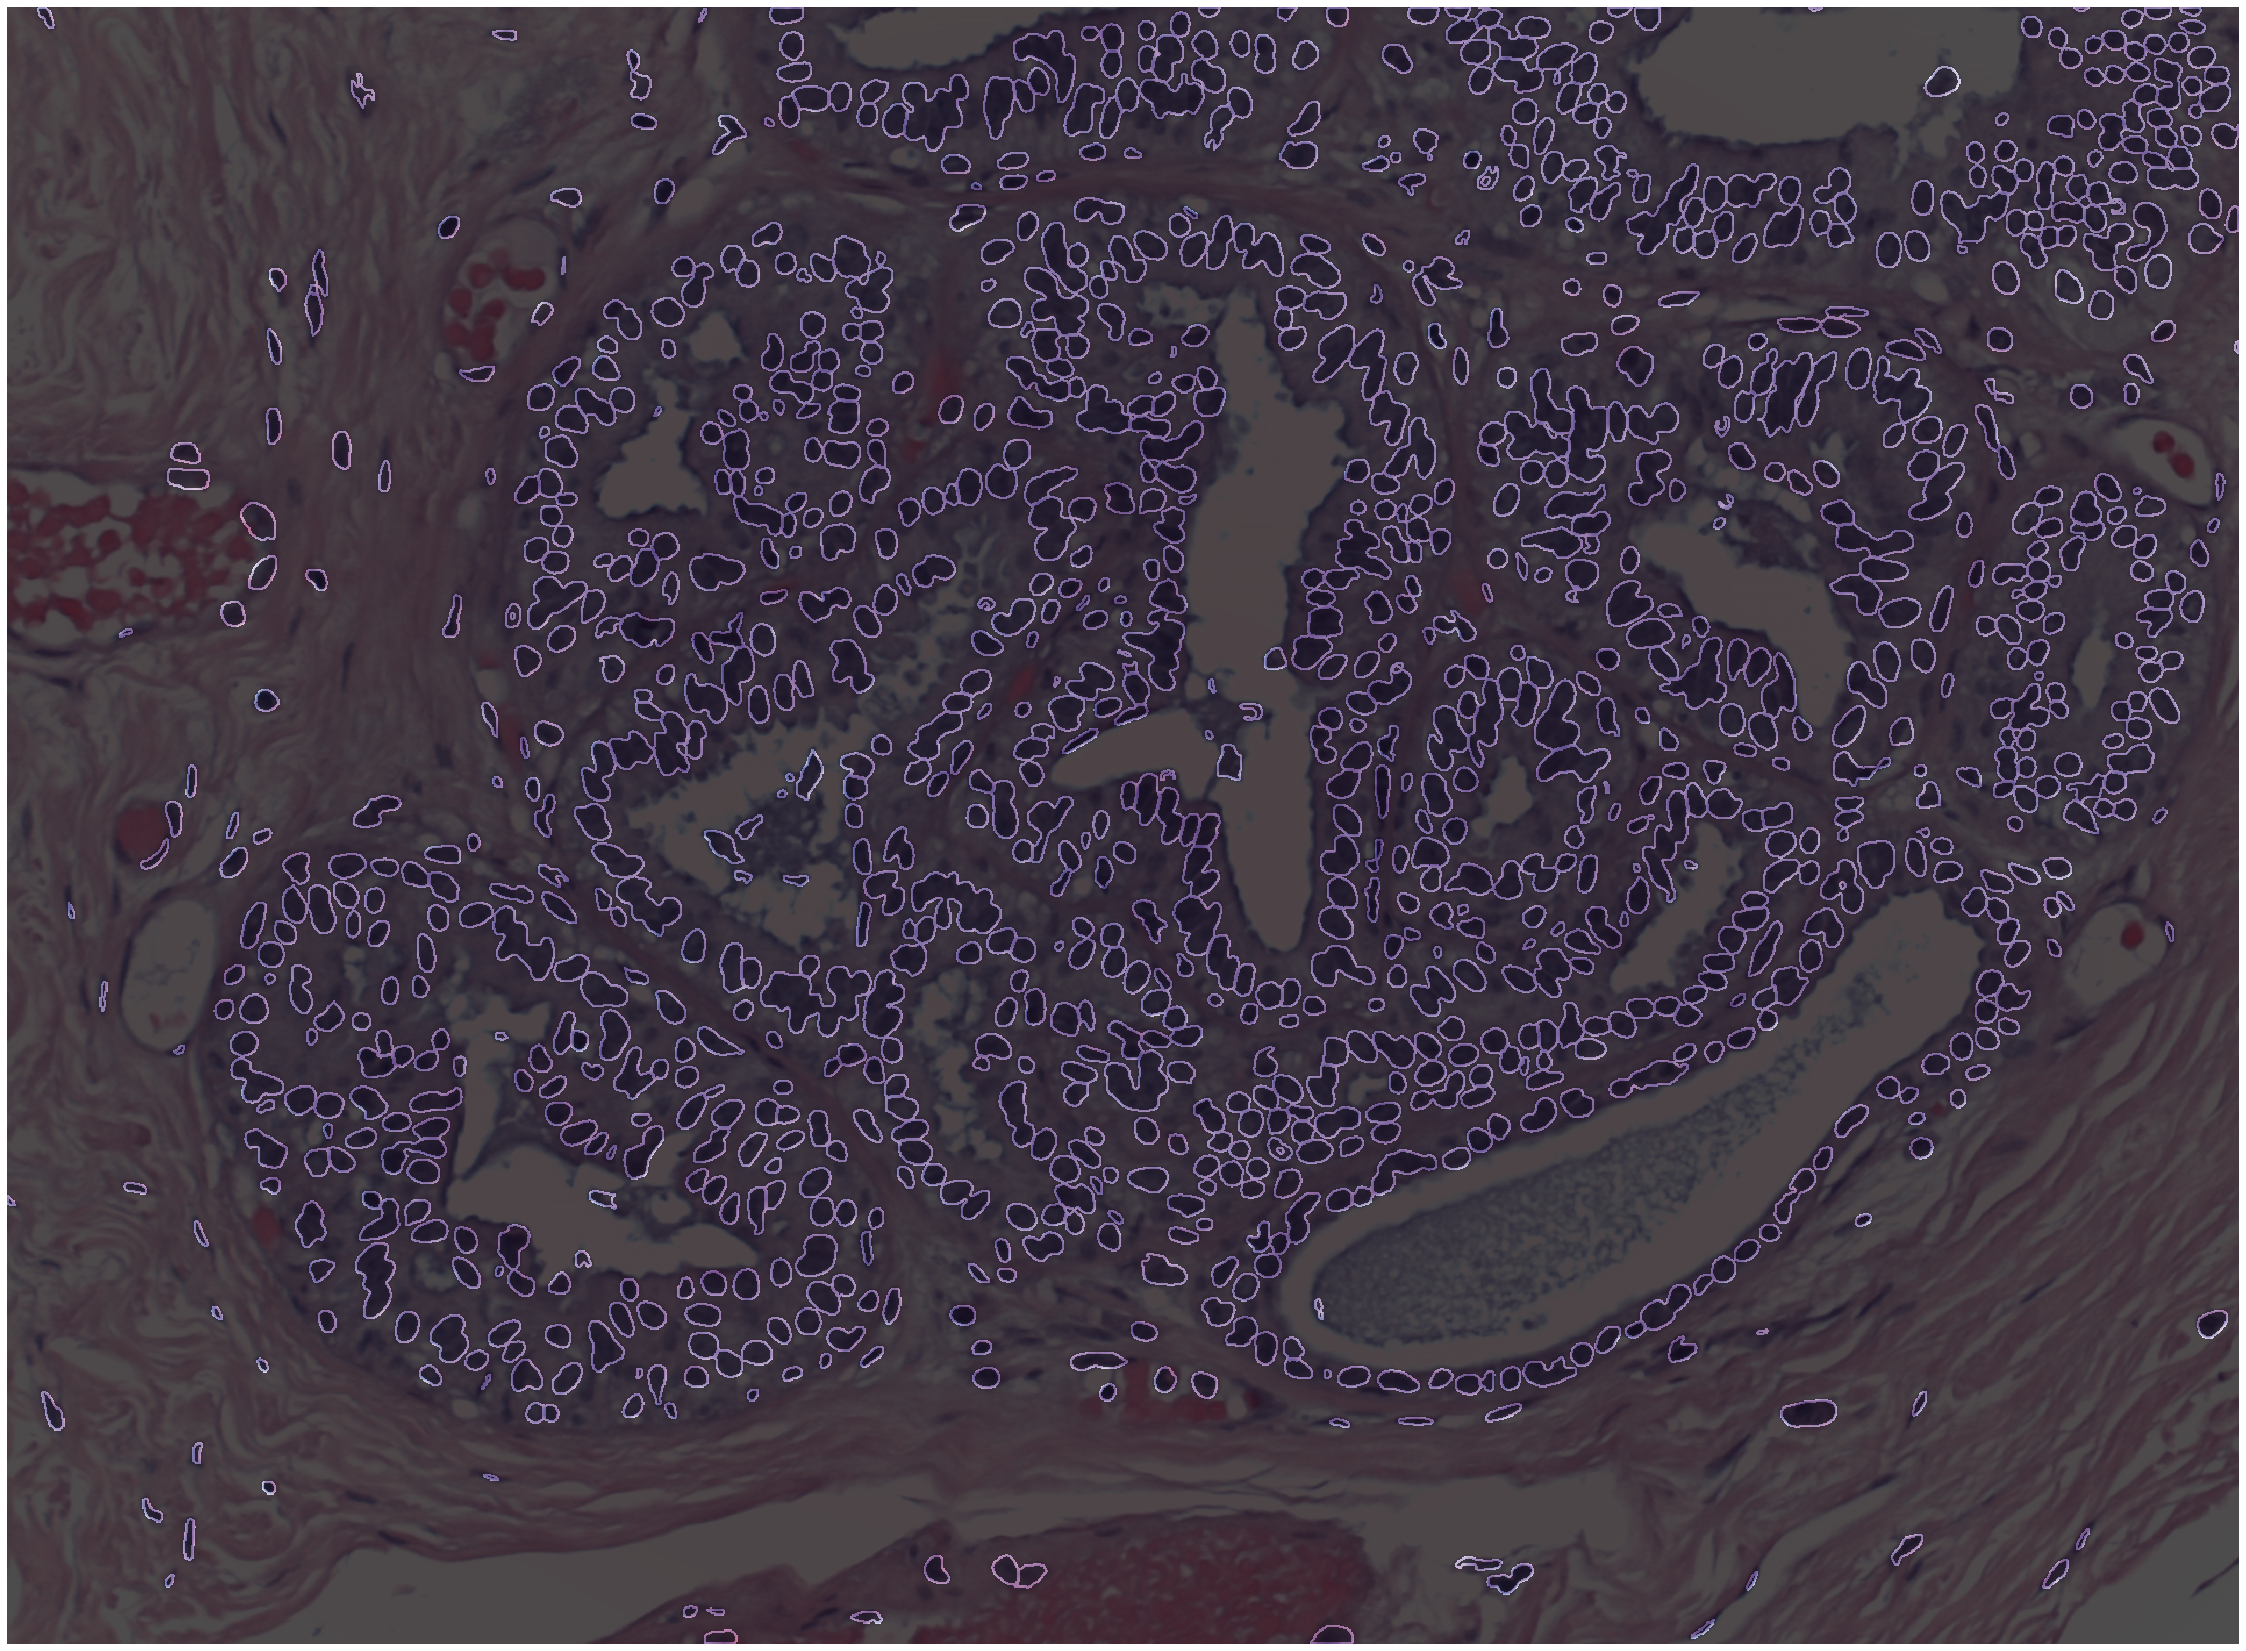

In [ ]:
# Make sure saved properly and loading properly
from src.vizualizations.cellseg_viz import instance_segmentation_vizualised
import matplotlib.pyplot as plt
import torch

sample = torch.load(os.path.join(prc_folder,"b002.pt"))
instance_segmentation_vizualised(sample["original_image"], sample["instance_mask"].squeeze(),figsize=(40,40))
plt.show()